<a href="https://colab.research.google.com/github/kunuit/Datamining_Customer_Airline_Satisfaction/blob/master/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime as dt

%matplotlib inline

# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## MODELING

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/public subject/olap/cleaned_data.csv')

In [ ]:
# Create X (Features Matrix)
X = df.drop("satisfaction", axis = 1)
# Create y (labels)
y = df["satisfaction"]
X.shape, y.shape

((129880, 28), (129880,))

In [ ]:
from sklearn.model_selection import train_test_split
# Split data into train and test sets
np.random.seed(44)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

We're going to try _three_ different machine learning models:

1. Logistic Regression
2. K-Nearest Neighbors
3. Random Forest

In [ ]:
%matplotlib inline

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, f1_score, roc_curve, plot_roc_curve


# Put models in a dictionary
models = {'Logistic Regression': LogisticRegression(max_iter=1000),
          'KNN': KNeighborsClassifier(),
          'Random Forest': RandomForestClassifier()}

# Create a function to fit and score models
def fit_and_score(models, Xtrain, Xtest, ytrain, ytest):
    """
    Fits and evaluates given machine learning models.
    models: a dict of different Scikit-Learn machine learning models
    Xtrain: training data (no labels)
    Xtest: testing data (no labels)
    ytrain: training labels
    ytest: test labels
    """
    # Set random seed
    np.random.seed(44)
    # Make a dictionary to keep model scores
    model_scores = {}
    for name, model in models.items():
        # Fit the model to the data
        model.fit(Xtrain, ytrain)
        # evaluate model and append score
        model_scores[name] = model.score(Xtest, ytest)
    return model_scores

In [ ]:
model_scores = fit_and_score(models=models,
                             Xtrain=Xtrain,
                             Xtest=Xtest,
                             ytrain=ytrain,
                             ytest=ytest)
model_scores

{'KNN': 0.8292783081819115,
 'Logistic Regression': 0.7945539472333436,
 'Random Forest': 0.9655322862129145}

## Model Comparison

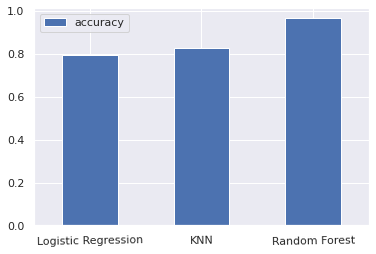

In [ ]:
model_compare = pd.DataFrame(model_scores, index=['accuracy'])
model_compare.T.plot.bar()
plt.xticks(rotation=1);

How to improve the baseline metrics?

| classification | regression                     |
| ---------------| -------------------------------|
| **accuracy**   | **r^2**                        |
| precision      | mean absolute error            |
| recall         | maen squared error (MSE)       |
| f1             | root mean squared error (RMSE) |

Ideas:

* hyperparameter tuning
* feature importance
* confusion matrix
* precision
* recall
* f1 score
* classification report
* roc curve
* area under the curve (AUC)

## Hyperparameter Tuning (by Hand)

In [ ]:
# Tune KNN
np.random.seed(44)

train_scores = []
test_scores = []

# Create a list of different values for n_neighbors
neighbors = range(1,21)

# Setup KNN instance
knn = KNeighborsClassifier()

# Loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)

    # Fit algorithm
    knn.fit(Xtrain, ytrain)

    # Update training scores list
    train_scores.append(knn.score(Xtrain, ytrain))

    # Update test_scores list
    test_scores.append(knn.score(Xtest, ytest))

In [ ]:
train_scores

[1.0,
 0.9021404373267632,
 0.9009635267719653,
 0.881429011395134,
 0.8806920674028774,
 0.8731246425271679,
 0.8722447094020854,
 0.8674380747063223,
 0.8674270755422588,
 0.8630054115887192,
 0.8629834132605922,
 0.8602446214087729,
 0.8602336222447095,
 0.8588477275727044,
 0.8588917242289587,
 0.8572198512913018,
 0.857428835408509,
 0.8561309340490123,
 0.8561749307052664,
 0.8554159883848828]

In [ ]:
test_scores

[0.8012267734318859,
 0.8102864182322144,
 0.8201673339492865,
 0.8290216610204291,
 0.8292783081819115,
 0.8371317113232728,
 0.8346678985730418,
 0.8397238476542449,
 0.8376706703623857,
 0.8413920542038805,
 0.8393645416281696,
 0.8424699722821065,
 0.840262806693358,
 0.8433425726311466,
 0.8420593368237347,
 0.8448567908838929,
 0.8430089313212196,
 0.8452674263422647,
 0.8435992197926291,
 0.8462170208397495]

Maximum KNN score on test data: 84.62%


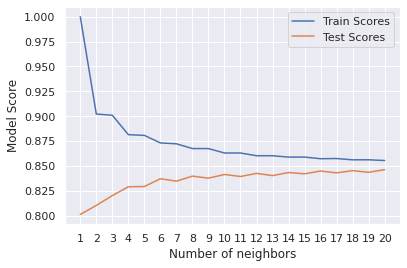

In [ ]:
plt.plot(neighbors, train_scores, label='Train Scores')
plt.plot(neighbors, test_scores, label='Test Scores')
plt.xticks(np.arange(1,21,1))
plt.xlabel('Number of neighbors')
plt.ylabel('Model Score')
plt.legend();

print(f"Maximum KNN score on test data: {max(test_scores)*100:.2f}%")

## Hyperparamter Tuning with RandomizedSearchCV

We're going to tune:
* LogisticRegression
* RandomForestClassifier

### Tuning Logistic Regression

In [ ]:
# Create a hyperparameter grid for LogisticRegression
log_reg_grid = {'C': np.logspace(-4, 4, 20),
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']}

# Create a hyperparameter grid for RandomClassifier
rf_grid = {'n_estimators': np.arange(10, 1000, 50),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2)}

In [ ]:
# Tune Logistic Regression

np.random.seed(44)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model for Logistic Regression
rs_log_reg.fit(Xtrain, ytrain)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=None,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C':...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+0

In [ ]:
rs_log_reg.best_params_

{'C': 29.763514416313132, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
rs_log_reg.score(Xtest, ytest)

0.8368493994456422

### Tuning Random Forest

In [ ]:
# Tune Random Forest

np.random.seed(44)

# Setup random hyperparameter search for LogisticRegression
rs_rf_reg = RandomizedSearchCV(RandomForestClassifier(),
                               param_distributions=rf_grid,
                               cv=5,
                               n_iter=10,
                               verbose=True)

# Fit random hyperparameter search model for Logistic Regression
rs_rf_reg.fit(Xtrain, ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 22.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
rs_rf_reg.best_params_

{'max_depth': None,
 'min_samples_leaf': 7,
 'min_samples_split': 4,
 'n_estimators': 560}

In [ ]:
# Evaluate the tuned model
rs_rf_reg.score(Xtest, ytest)

0.9638384149471307

### Compare hypertuned models

In [ ]:
tuned_model_scores = fit_and_score(models={'RS Logistic Regression': rs_log_reg,
                                           'RS Random Forest': rs_rf_reg},
                                   Xtrain=Xtrain,
                                   Xtest=Xtest,
                                   ytrain=ytrain,
                                   ytest=ytest)
tuned_model_scores

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 26.3min finished


{'RS Logistic Regression': 0.8368493994456422,
 'RS Random Forest': 0.9647623447284673}

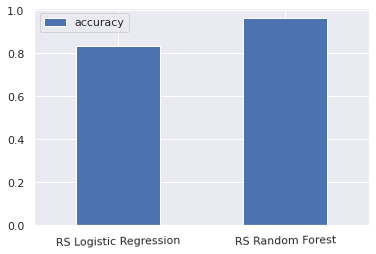

In [ ]:
tuned_model_compare = pd.DataFrame(tuned_model_scores, index=['accuracy'])
tuned_model_compare.T.plot.bar()
plt.xticks(rotation=1);

## Hyperparameter Tuning with GridSearchCV

Since our Logisti Regression model provides the best scores so far, we'll try to improve the model further using GridSearchCV

In [ ]:
# Create a hyperparameter grid for LogisticRegression with liblinear solver
log_reg_libnear_grid = {'C': np.logspace(-4, 4, 30),
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg_liblinear = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit model
gs_log_reg_liblinear.fit(Xtrain, ytrain)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
# Check best parameters
gs_log_reg_liblinear.best_params_

{'C': 1.623776739188721, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
# Evaluate grid search Logistic Regression model
gs_log_reg_liblinear.score(Xtest, ytest)

0.8359254696643055

In [ ]:
# Create a hyperparameter grid for LogisticRegression
log_reg_libnear_grid = {'C': np.logspace(-4, 4, 30),
                'penalty': ['l1', 'l2'],
                'solver': ['liblinear']}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg_liblinear = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit model
gs_log_reg_liblinear.fit(Xtrain, ytrain)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 2.6...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
      

In [ ]:
# Create a hyperparameter grid for LogisticRegression with lbfgs solver
log_reg_libnear_grid = {'C': np.logspace(-4, 4, 30),
                'penalty': [None, 'l2'],
                'solver': ['lbfgs']}

# Setup grid hyperparameter search for LogisticRegression
gs_log_reg_lbfgs = GridSearchCV(LogisticRegression(),
                          param_grid=log_reg_grid,
                          cv=5,
                          verbose=True)

# Fit model
gs_log_reg_lbfgs.fit(Xtrain, ytrain)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.00000000e-04, 2.6...
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
      

In [ ]:
gs_log_reg_lbfgs.best_params_

{'C': 1438.44988828766, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
gs_log_reg_lbfgs.score(Xtest, ytest)

0.8366954111487527

In [ ]:
rs_model_scores = fit_and_score(models={'Baseline Logistic Regression': LogisticRegression(max_iter=1000),
                                        'RS Log. Regression': rs_log_reg,
                                        'Grid Search with liblinear': gs_log_reg_liblinear,
                                        'Grid Search with lbfgs': gs_log_reg_lbfgs},
                                   Xtrain=Xtrain,
                                   Xtest=Xtest,
                                   ytrain=ytrain,
                                   ytest=ytest)
rs_model_scores

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.3min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.4min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  4.2min finished


{'Baseline Logistic Regression': 0.7945539472333436,
 'Grid Search with lbfgs': 0.8367980700133456,
 'Grid Search with liblinear': 0.8369263935940868,
 'RS Log. Regression': 0.8368493994456422}

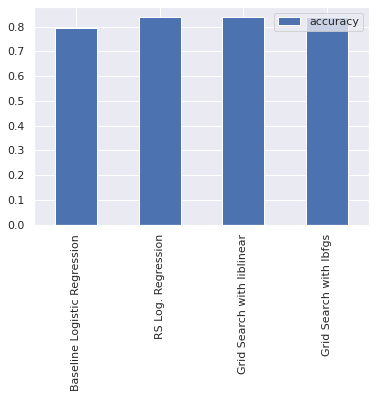

In [ ]:
rs_model_compare = pd.DataFrame(rs_model_scores, index=['accuracy'])
rs_model_compare.T.plot.bar();

## Evaluating tuned machine learning classifier, beyond accuracy

* ROC curve, AUC curve
* Confusion matrix
* Classificatoin report
* Precision
* Recall
* F1-score

... with cross-validation where possible.

To make comparions and evaluate our trained model, we need to make predictions first.

### ROC curve and AUC metric

In [ ]:
# Make predictions with best tuned model on test/train-split data-
ypreds = rs_log_reg.predict(Xtest)

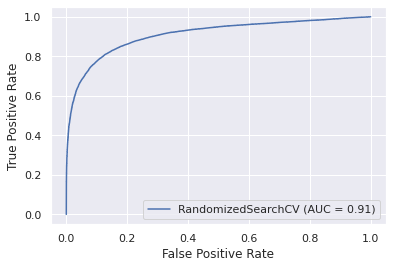

In [ ]:
# Plot ROC curve and calculate AUC metric
plot_roc_curve(rs_log_reg, Xtest, ytest);

### Confusion Matrix

In [ ]:
# Confusion matrix
cm = confusion_matrix(ytest, ypreds)

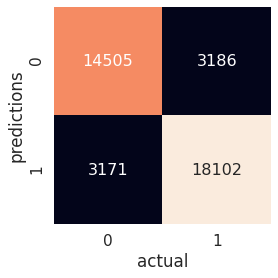

In [ ]:
# Plot confusion matrix
sns.set(font_scale=1.4)
sns.heatmap(cm.T, annot=True, fmt='d', annot_kws={"size": 16}, square=True, cbar=False)
plt.xlabel('actual')
plt.ylabel('predictions');

### Classifiction Report

In [ ]:
# Classification Report on train/test-split data
print(classification_report(ytest, ypreds))

              precision    recall  f1-score   support

           1       0.82      0.82      0.82     17676
           2       0.85      0.85      0.85     21288

    accuracy                           0.84     38964
   macro avg       0.84      0.84      0.84     38964
weighted avg       0.84      0.84      0.84     38964



### Cross-validated evaluation metrics

In [ ]:
# Check best hyperparameters
rs_log_reg.best_params_

{'C': 29.763514416313132, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
# Create a new classifier with best parameters
clf = LogisticRegression(C=29.763514416313132,
                         solver='liblinear',
                         penalty='l1')

In [ ]:
def average_metric(clf, X, y, scoring):
    """
    Returns the average score on each scoring metric, rounded to 2 decimals.
    clf: scikit-learn classification
    X: features (no labels)
    y: labels
    scoring: scoring metric
    """
    return round((np.mean(cross_val_score(clf, X, y, cv=5, scoring=scoring))), 2)


def average_score_on_cross_val_classification(clf, X, y):
    """
    Evaluates a given model/estimator using cross-validation (5 folds)
    and returns a dict containing the average (mean) scores
    for classification models

    clf: scikit-learn classification
    X: features (no labels)
    y: labels
    """
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    scores = {metric: average_metric(clf, X, y, metric) for metric in metrics}

    return scores

In [ ]:
cv_metrics = average_score_on_cross_val_classification(clf, X, y)
cv_metrics

{'accuracy': 0.68, 'f1': 0.62, 'precision': 0.73, 'recall': 0.65}

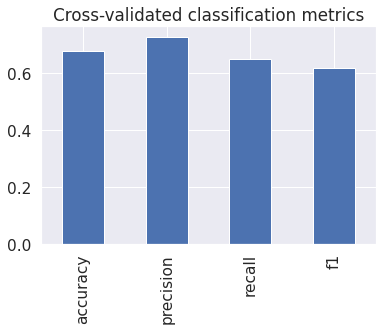

In [ ]:
# Create visualization
cv_metrics_df = pd.DataFrame(cv_metrics, index=[0])

cv_metrics_df.T.plot.bar(title='Cross-validated classification metrics',
                         legend=False);
